# Binary classification (1 vs rest)

#### Импорт необходимых библиотек

In [1]:
from google.colab import drive

drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%ls

In [2]:
!pip install tensorflow-addons
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%cd drive/MyDrive/YaMlProject/models/models/one_vs_all

[WinError 3] Системе не удается найти указанный путь: 'drive/MyDrive/YaMlProject/models/models/one_vs_all'
d:\MainFolder\YaMlProject\models\models\1


In [4]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/226.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/226.0 kB ? eta -:--:--
     - -------------------------------------- 10.2/226.0 kB ? eta -:--:--
     - -------------------------------------- 10.2/226.0 kB ? eta -:--:--
     - -------------------------------------- 10.2/226.0 kB ? eta -:--:--
     - -------------------------------------- 10.2/226.0 kB ? eta -:--:--
     ----- ------------------------------- 30.7/226.0 kB 163.8 kB/s eta 0:00:02
     ------ ------------------------------ 41.0/226.0 kB 179.6 kB/s eta 0:00:02
     ----------- ------------------------- 71.7/226.0 kB 302.7 kB/s eta 0:00:01
     ----------------- ------------------ 112.6/226.0 kB 409.6 kB/s eta 0:00:01
     ---------------------- ------------- 143.4/226.0 kB 473.7 kB/s eta 0:00:01
     --------------------------- -------- 174.1/226.0 kB 499.5 kB/s eta 0:00:01



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import seaborn
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sys.path.append('../../../')

from core.datasets import get_ds, open_f, DataSequence
from core.make_answer import make_ans_file

C:\Users\Salam\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_model = '_four'

#### Формируем аугментацию.

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

скачиваем файлы

In [4]:
batch_size = 100
data_all = open_f('repaired_data_train', 3)
data_test = open_f('repaired_data_test', 3)

меняем labels на 1/0 в зависимости от того, была ли изначально 1

In [5]:
print('До:', data_all['labels'])
data_all['labels'] = np.int0(data_all['labels'] == 4)
print('После:', data_all['labels'])

До: [1 3 2 ... 7 5 8]
После: [0 0 0 ... 0 0 0]


C:\Users\Salam\AppData\Local\Temp\ipykernel_9424\668571239.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  data_all['labels'] = np.int0(data_all['labels'] == 4)


In [6]:
sm = SMOTE(random_state=42)
X_train, y_train = data_all['images'], data_all['labels']
X_train_copy = X_train.reshape(len(X_train), -1)
y_train_copy = y_train
X_train_sm, y_train_sm = sm.fit_resample(X_train_copy, y_train_copy)
X_train_sm = X_train_sm.reshape(-1, 32, 32, 3)
data_all['images'], data_all['labels'] = X_train_sm, y_train_sm

парсинг данных в 3 датасета

In [7]:
shuffle = np.random.permutation(data_all['labels'].shape[0])
train_images_full = data_all['images'][shuffle]
train_labels_full = data_all['labels'][shuffle]
train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full,
                                                              test_size=0.12, random_state=1234)

val_ds = tf.data.Dataset.from_tensor_slices((val_ds_x / 255., val_ds_y))
val_ds = val_ds.batch(batch_size)
train_ds = DataSequence(train_ds_x, train_ds_y, transformer, batch_size=batch_size)

test_ds = data_test['images'] / 255.

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [8]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

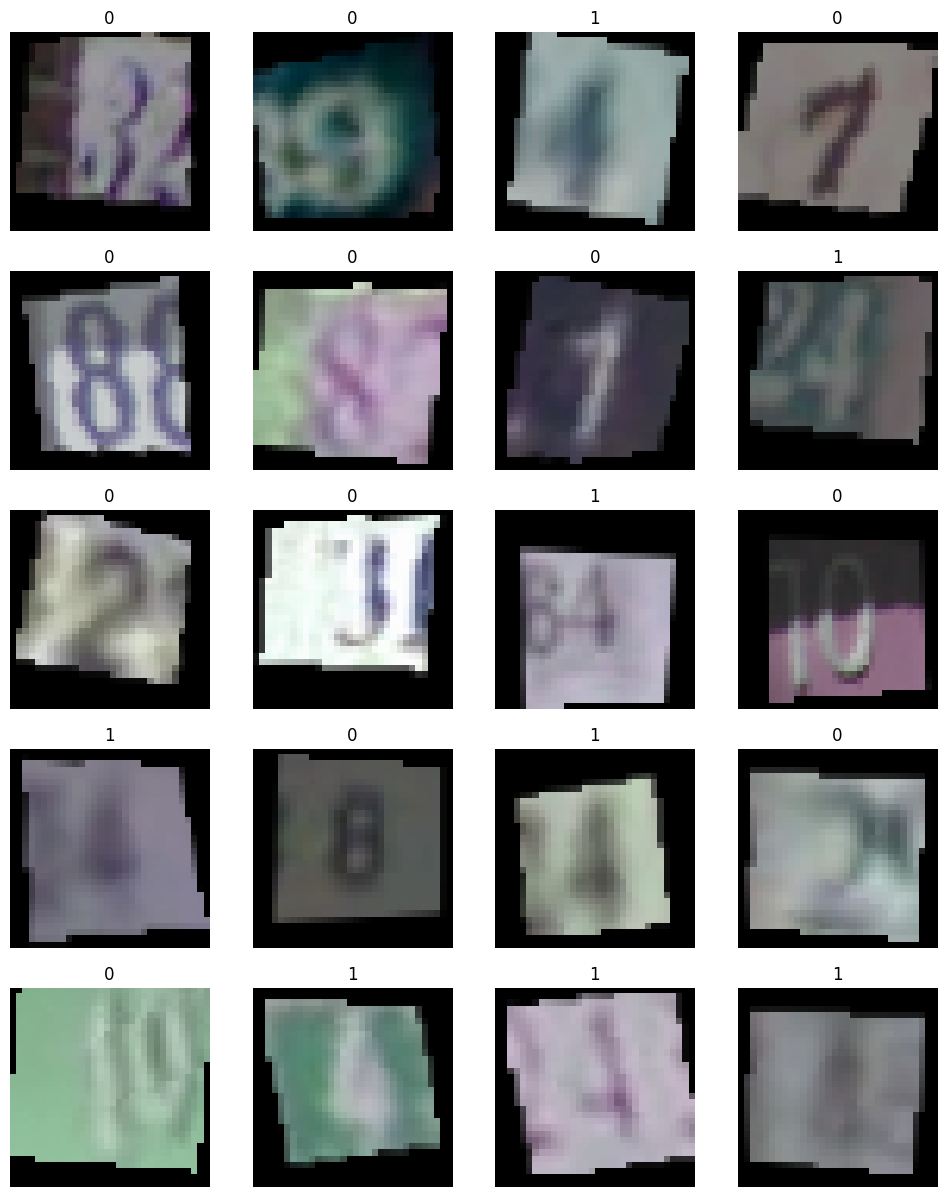

In [9]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(train_ds_visualization[1][i])
    plt.axis('off')
plt.show()

#### Пишем модель

In [10]:
def tree(x, filters, kernel_size, strides=1, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)

In [11]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
fork = tf.keras.layers.ReLU()(x)

In [12]:
tree1 = tree(fork, 16, 1, strides=1)
tree2 = tree(fork, 16, 3, strides=1)
tree3 = tree(fork, 16, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 32, 32, 64])

In [13]:
tree1 = tree(fork, 48, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 15, 15, 112])

In [14]:
tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 15, 15, 192])

In [15]:
tree1 = tree(fork, 64, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 7, 7, 256])

In [16]:
tree1 = tree(fork, 64, 1, strides=1)
tree2 = tree(fork, 64, 3, strides=1)
tree3 = tree(fork, 64, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.add([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 7, 7, 64])

In [17]:
x = tf.keras.layers.GlobalAveragePooling2D()(fork)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [18]:
metrics = ['accuracy']
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [19]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [20]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.002)),
    metrics=metrics,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

#### Обучаем модель

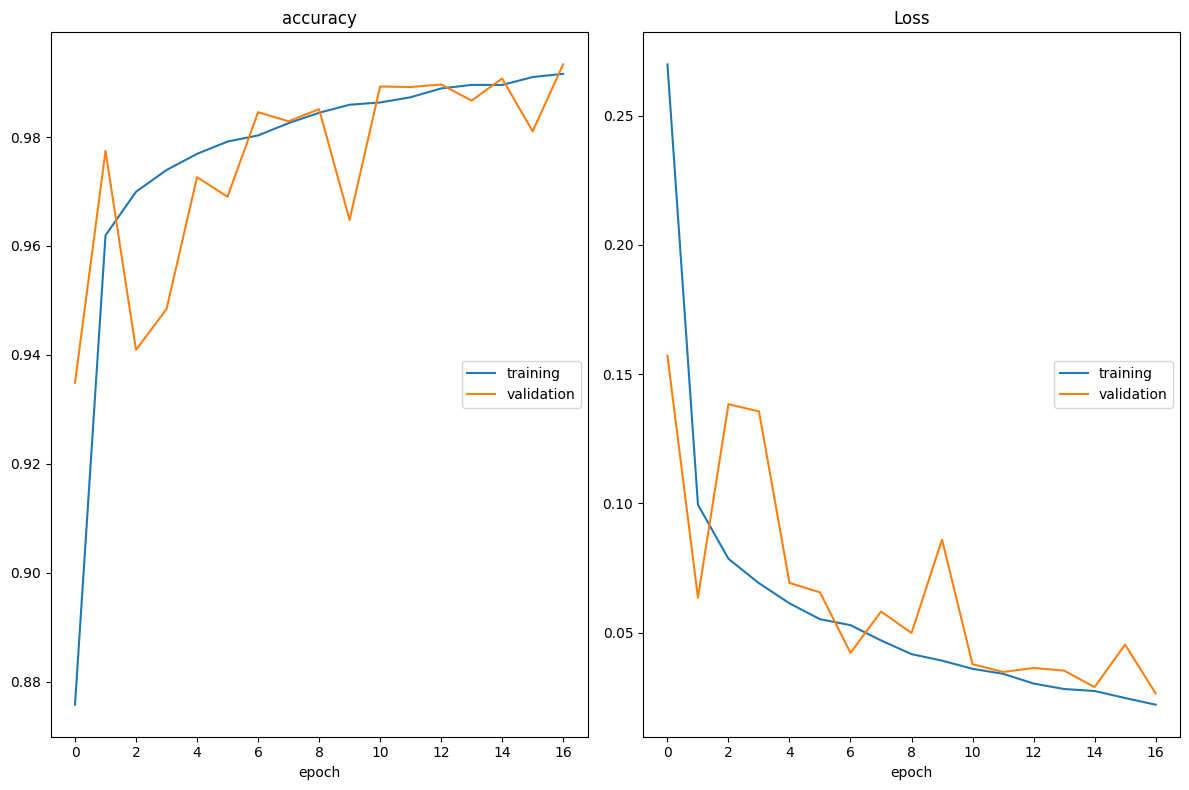

accuracy
	training         	 (min:    0.876, max:    0.992, cur:    0.992)
	validation       	 (min:    0.935, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.022, max:    0.270, cur:    0.022)
	validation       	 (min:    0.027, max:    0.157, cur:    0.027)
794/794 [==============================] - 600s 756ms/step - loss: 0.0222 - accuracy: 0.9916 - val_loss: 0.0265 - val_accuracy: 0.9933 - lr: 0.0016
Epoch 18/100
174/794 [=====>........................] - ETA: 7:46 - loss: 0.0217 - accuracy: 0.9916

KeyboardInterrupt: 

In [21]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)